In [1]:
# baseado em https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/
# https://www.codigofluente.com.br/aula-06-scikit-learn-vizinhos-mais-proximos-knn/
# https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/classification/notebooks/Correcting%20for%20imbalanced%20datasets.ipynb#scrollTo=jq9376MGvTa7

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import cluster, neighbors, svm, metrics, preprocessing
import math
np.set_printoptions(suppress=True)

In [3]:
originalDF = pd.read_csv('penguins_size.csv', encoding = "ISO-8859-1")

In [4]:
from sklearn import preprocessing
 
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
encodedDF = originalDF.copy()
encodedDF['island']= label_encoder.fit_transform(encodedDF['island'])
encodedDF['sex']= label_encoder.fit_transform(encodedDF['sex'])
encodedDF['species']= label_encoder.fit_transform(encodedDF['species'])

encodedDF = encodedDF[~np.isnan(encodedDF).any(axis=1)]
# pd.set_option('display.max_rows', encodedDF.shape[0]+1)
encodedDF.reset_index(drop=True, inplace=True)
encodedDF

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,39.1,18.7,181.0,3750.0,2
1,0,2,39.5,17.4,186.0,3800.0,1
2,0,2,40.3,18.0,195.0,3250.0,1
3,0,2,36.7,19.3,193.0,3450.0,1
4,0,2,39.3,20.6,190.0,3650.0,2
...,...,...,...,...,...,...,...
337,2,0,47.2,13.7,214.0,4925.0,1
338,2,0,46.8,14.3,215.0,4850.0,1
339,2,0,50.4,15.7,222.0,5750.0,2
340,2,0,45.2,14.8,212.0,5200.0,1


In [5]:
from sklearn.preprocessing import StandardScaler

scaledArr = StandardScaler().fit_transform(encodedDF.loc[:, ['island','culmen_length_mm','culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']].values)
scaledDF = pd.DataFrame(data = scaledArr, columns = ['island','culmen_length_mm','culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']) 
# pd.set_option('display.max_rows', scaledDF.shape[0]+1)
scaledDF

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,1.852870,-0.884499,0.785449,-1.418347,-0.564142,0.846836
1,1.852870,-0.811126,0.126188,-1.062250,-0.501703,-0.974660
2,1.852870,-0.664380,0.430462,-0.421277,-1.188532,-0.974660
3,1.852870,-1.324737,1.089724,-0.563715,-0.938776,-0.974660
4,1.852870,-0.847812,1.748985,-0.777373,-0.689020,0.846836
...,...,...,...,...,...,...
337,-0.914298,0.601305,-1.750171,0.931890,0.903175,-0.974660
338,-0.914298,0.527932,-1.445897,1.003109,0.809516,-0.974660
339,-0.914298,1.188289,-0.735923,1.501644,1.933419,0.846836
340,-0.914298,0.234440,-1.192335,0.789451,1.246590,-0.974660


In [6]:
scaledDF = pd.concat([scaledDF, encodedDF[['species']]], axis = 1)
scaledDF

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,species
0,1.852870,-0.884499,0.785449,-1.418347,-0.564142,0.846836,0
1,1.852870,-0.811126,0.126188,-1.062250,-0.501703,-0.974660,0
2,1.852870,-0.664380,0.430462,-0.421277,-1.188532,-0.974660,0
3,1.852870,-1.324737,1.089724,-0.563715,-0.938776,-0.974660,0
4,1.852870,-0.847812,1.748985,-0.777373,-0.689020,0.846836,0
...,...,...,...,...,...,...,...
337,-0.914298,0.601305,-1.750171,0.931890,0.903175,-0.974660,2
338,-0.914298,0.527932,-1.445897,1.003109,0.809516,-0.974660,2
339,-0.914298,1.188289,-0.735923,1.501644,1.933419,0.846836,2
340,-0.914298,0.234440,-1.192335,0.789451,1.246590,-0.974660,2


In [7]:
corr = scaledDF.corr()
corr.style.background_gradient(cmap='coolwarm')

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,species
island,1.000000,-0.353647,0.571035,-0.565825,-0.561515,0.037362,-0.633150
culmen_length_mm,-0.353647,1.000000,-0.235053,0.656181,0.595110,0.269434,0.731369
culmen_depth_mm,0.571035,-0.235053,1.000000,-0.583851,-0.471916,0.322860,-0.744076
flipper_length_mm,-0.565825,0.656181,-0.583851,1.000000,0.871202,0.197440,0.854307
body_mass_g,-0.561515,0.595110,-0.471916,0.871202,1.000000,0.347376,0.750491
sex,0.037362,0.269434,0.322860,0.197440,0.347376,1.000000,-0.012056
species,-0.633150,0.731369,-0.744076,0.854307,0.750491,-0.012056,1.000000


In [8]:
y = scaledDF.loc[:, ['species']].values
X = scaledDF.loc[:, ['island','culmen_length_mm','culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']].values
X

array([[ 1.85286967, -0.88449874,  0.78544923, -1.41834665, -0.56414208,
         0.84683555],
       [ 1.85286967, -0.81112573,  0.1261879 , -1.06225022, -0.50170305,
        -0.97465979],
       [ 1.85286967, -0.66437972,  0.43046236, -0.42127665, -1.18853234,
        -0.97465979],
       ...,
       [-0.91429814,  1.18828874, -0.73592307,  1.50164406,  1.93341896,
         0.84683555],
       [-0.91429814,  0.23443963, -1.19233476,  0.7894512 ,  1.24658968,
        -0.97465979],
       [-0.91429814,  1.09657248, -0.53307343,  0.86067049,  1.49634578,
         0.84683555]])

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['Componente Principal 1', 'Componente Principal 2'])

finalDf = pd.concat([principalDf, scaledDF[['species']]], axis = 1)
finalDf['species'] = label_encoder.inverse_transform(scaledDF['species'])
finalDf

,Componente Principal 1,Componente Principal 2,species
0,-2.330493,1.123742,Adelie
1,-2.043549,-0.534049,Adelie
2,-2.109898,-0.419954,Adelie
3,-2.566098,-0.221928,Adelie
4,-2.401836,1.643673,Adelie
...,...,...,...
337,2.092390,-1.520909,Gentoo
338,1.940461,-1.394787,Gentoo
339,2.968940,0.724001,Gentoo
340,1.838221,-1.280319,Gentoo


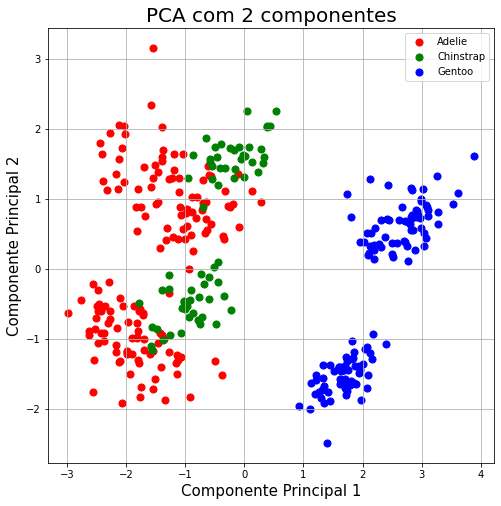

In [10]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Componente Principal 1', fontsize = 15)
ax.set_ylabel('Componente Principal 2', fontsize = 15)
ax.set_title('PCA com 2 componentes', fontsize = 20)
targets = ['Adelie', 'Chinstrap', 'Gentoo']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['species'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'Componente Principal 1']
               , finalDf.loc[indicesToKeep, 'Componente Principal 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [12]:
# n_neighbors=1: macro avg       0.92      0.92      0.92
# n_neighbors=2: macro avg       0.87      0.87      0.87
# n_neighbors=3: macro avg       0.89      0.88      0.87
# n_neighbors=4: macro avg       0.84      0.84      0.8
# n_neighbors=5: macro avg       0.78      0.80      0.78

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(X_train, y_train)

C:\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=1)

In [13]:
y_pred = classifier.predict(X_test)

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[36  2  0]
 [ 0 11  0]
 [ 0  0 20]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        38
           1       0.85      1.00      0.92        11
           2       1.00      1.00      1.00        20

    accuracy                           0.97        69
   macro avg       0.95      0.98      0.96        69
weighted avg       0.98      0.97      0.97        69

